## 교차 검증과 그리드 서치

이전까지는 테스트 세트를 사용하여 모델을 평가했지만 자주 확인한다면 점점 테스트 세트에 맞추게 됨<br>
마지막에 딱 한 번만 사용하는 것이 좋음<br>

### 검증 세트
<U>훈련세트에서 또 나눔!</U><br>
이 데이터를 **검증 세트**라고 함<br>
그래서 이번에는 훈련세트 60%, 검증세트 20%, 테스트세트 20%로 나눔

In [1]:
import pandas as pd

data=pd.read_csv('wine.csv')
print(data.head())

   Unnamed: 0  alcohol  sugar    pH  class
0           0      9.4    1.9  3.51    0.0
1           1      9.8    2.6  3.20    0.0
2           2      9.8    2.3  3.26    0.0
3           3      9.8    1.9  3.16    0.0
4           4      9.4    1.9  3.51    0.0


In [5]:
x=data[['alcohol','sugar','pH']].to_numpy()
y=data['class'].to_numpy()

In [8]:
from sklearn.model_selection import train_test_split
#train_test_split() 함수를 2번 적용하여 훈련세트와 검증세트를 나눔

train_input, test_input, train_target, test_target = train_test_split(x,y,test_size=0.2,random_state=42)

In [9]:
sub_input, val_input, sub_target, val_target = train_test_split(train_input,train_target,test_size=0.2,random_state=42)

In [10]:
print(train_input.shape)
print(sub_input.shape) #훈련세트
print(val_input.shape) #검증세트

(5197, 3)
(4157, 3)
(1040, 3)


In [15]:
index0=(val_target==0)
print(index0)

[ True  True  True ... False False False]


In [16]:
index1=(val_target==1)
print(index1)

[False False False ...  True  True  True]


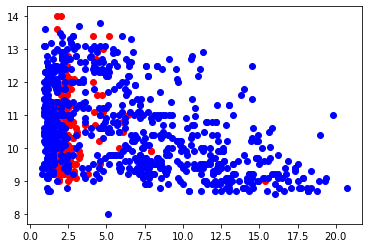

In [17]:
plt.scatter(val_input[index0,1],val_input[index0,0],c="#ff0000")
plt.scatter(val_input[index1,1],val_input[index1,0],c="#0000ff")
plt.show()

In [18]:
from sklearn.tree import DecisionTreeClassifier
#과대적합

dt=DecisionTreeClassifier(random_state=42)
dt.fit(sub_input,sub_target)

print(dt.score(sub_input,sub_target))
print(dt.score(val_input,val_target))

0.9971133028626413
0.864423076923077


In [19]:
pred=dt.predict([[9.4,1.9,3.51],[9.3,1.5,3.5]])
print(pred)
print(dt.)

[0. 0.]


### 교차 검증
검증 세트를 만드느라 훈련 세트가 줄었음 보통 많은 데이터를 훈련에 사용하면 좋지만 너무 적은 검증 세트는 불안정하고 좋지않음<br>
이럴 때 **교차 검증**을 이용하여 안정적인 검증 점수를 얻음<br><br>
다음은 3-폴드 교차 검증그림 (보통 5-폴드 교차 검증이나 10-폴드 교차 검증을 많이 사용함)
![교차검증](https://thebook.io/img/006975/130.jpg)

In [20]:
from sklearn.model_selection import cross_validate

#처음 두 키는 각각 모델을 훈련하는 시간과 검증하는 시간을 의미
#기본적으로 5-폴드 교차 검증 수행
scores=cross_validate(dt,train_input,train_target)
print(scores)

{'fit_time': array([0.00598431, 0.0039885 , 0.0039897 , 0.00398946, 0.00398898]), 'score_time': array([0.        , 0.        , 0.00099707, 0.        , 0.        ]), 'test_score': array([0.86923077, 0.84615385, 0.87680462, 0.84889317, 0.83541867])}


In [21]:
import numpy as np

print(np.mean(scores['test_score']))

0.855300214703487


In [22]:
from sklearn.model_selection import StratifiedKFold

#분류 모델일 경우 타깃 클래스를 골고루 나누기 위해 StratifiedKFold를 사용
scores=cross_validate(dt,train_input,train_target,cv=StratifiedKFold())
print(np.mean(scores['test_score']))

0.855300214703487


In [23]:
#훈련 세트를 섞은 후 10-폴드 교차 검증 수행
splitter=StratifiedKFold(n_splits=10,shuffle=True,random_state=42)
scores=cross_validate(dt,train_input,train_target,cv=splitter)
print(np.mean(scores['test_score']))

0.8574181117533719


### 하이퍼파라미터 튜닝

In [24]:
from sklearn.model_selection import GridSearchCV #하이퍼파라미터 탐색과 교차 검증을 한 번에 수행
params={'min_impurity_decrease':[0.001,0.002,0.003,0.004,0.005]}

In [27]:
gs=GridSearchCV(DecisionTreeClassifier(random_state=42),params,n_jobs=-1) #시스템에 있는 모든 코어를 사용

In [34]:
gs.fit(train_input,train_target) #결정 트리 모델 min_impurity_decrease 값을 바꿔가며 총 5번 실행

GridSearchCV(estimator=DecisionTreeClassifier(random_state=42), n_jobs=-1,
             param_grid={'min_impurity_decrease': [0.001, 0.002, 0.003, 0.004,
                                                   0.005]})

In [35]:
#Gridsearch는 훈련이 끝나면 검증 점수가 가장 높은 모델의 매개변수 조합으로 전체 훈련세트에 자동으로 다시 모델을 훈련함
dt=gs.best_estimator_ #최적의 매개변수가 저장됨
print(dt.score(train_input,train_target))

0.8724263998460651


In [36]:
print(gs.best_params_)

{'min_impurity_decrease': 0.001}


In [37]:
print(gs.cv_results_['mean_test_score'])

[0.86165044 0.85761105 0.85607111 0.85414803 0.85318557]


In [38]:
best_index = np.argmax(gs.cv_results_['mean_test_score'])
print(gs.cv_results_['params'][best_index])

{'min_impurity_decrease': 0.001}


1. 먼저 탐색할 매개변수 지정<br>
2. 그 다음 훈련 세트에서 그리드 서치를 수행하여 최상의 평균 검증 점수가 나오는 매개변수 조합을 찾음, 그리고 객체에 저장됨<br>
3. 그리드 서치는 최상의 매개변수에서 전체 훈련 세트를 사용해 최종 모델을 훈련, 이 모델도 그리드 서치 객체 저정됨<br><br>
조금 더 복잡한 매개변수 조합은 max_depth로 트리의 깊이, min_samples_split으로 노드를 나누기 위한 최소 샘플 수 지정

In [39]:
#총 9x15x10=1,350번 교차 검증함
#기본 5-폴드 교차 검증을 수행하므로 6,750개의 모델이 만들어짐 
params = {'min_impurity_decrease': np.arange(0.0001, 0.001, 0.0001),
          'max_depth': range(5, 20, 1),
          'min_samples_split': range(2, 100, 10)
          }

In [40]:
gs = GridSearchCV(DecisionTreeClassifier(random_state=42), params, n_jobs=-1)
gs.fit(train_input, train_target)

GridSearchCV(estimator=DecisionTreeClassifier(random_state=42), n_jobs=-1,
             param_grid={'max_depth': range(5, 20),
                         'min_impurity_decrease': array([0.0001, 0.0002, 0.0003, 0.0004, 0.0005, 0.0006, 0.0007, 0.0008,
       0.0009]),
                         'min_samples_split': range(2, 100, 10)})

In [41]:
print(gs.best_params_)

{'max_depth': 14, 'min_impurity_decrease': 0.0004, 'min_samples_split': 12}


In [42]:
print(np.max(gs.cv_results_['mean_test_score']))

0.8683865773302731


### 랜덤 서치
매개변수의 값이 수치일 때 값의 범위나 간격을 미리 정하기 어렵거나 너무 많은 조건이 있어 그리드 서치 수행 시간이 오래 걸릴 수 있음<br>
**랜덤 서치**를 사용하여 매개변수를 샘플링할 수 있는 확률 분포 객체를 전달함

In [43]:
from scipy.stats import uniform,randint #균등 분포에서 샘플링, uniform은 실숫값 randint는 정숫값 뽑음

In [44]:
rgen=randint(0,10)
rgen.rvs(10)

array([5, 1, 8, 8, 5, 6, 9, 9, 5, 5])

In [45]:
np.unique(rgen.rvs(1000),return_counts=True)

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),
 array([117, 101,  92,  85,  93,  92,  99, 106, 121,  94], dtype=int64))

In [46]:
ugen = uniform(0, 1)
ugen.rvs(10)

array([0.44423298, 0.824947  , 0.26675825, 0.40426508, 0.45416524,
       0.29628519, 0.11258913, 0.17840249, 0.91895079, 0.58431846])

In [47]:
params = {'min_impurity_decrease': uniform(0.0001, 0.001),
          'max_depth': randint(20, 50),
          'min_samples_split': randint(2, 25),
          'min_samples_leaf': randint(1, 25), #리프 노드가 되기위한 최소 샘플의 개수
          }
#자식 노드의 샘플 수가 min_samples_leaf보다 값이 작을 경우 분할하지 않음

In [48]:
from sklearn.model_selection import RandomizedSearchCV

#그리드 서치보다 교차 검증 수를 줄이면서 넓은 영역을 효과적으로 탐색할 수 있음
gs = RandomizedSearchCV(DecisionTreeClassifier(random_state=42), params, 
                        n_iter=100, n_jobs=-1, random_state=42) #100번 수행
gs.fit(train_input, train_target)

RandomizedSearchCV(estimator=DecisionTreeClassifier(random_state=42),
                   n_iter=100, n_jobs=-1,
                   param_distributions={'max_depth': <scipy.stats._distn_infrastructure.rv_frozen object at 0x00000272CAE882B0>,
                                        'min_impurity_decrease': <scipy.stats._distn_infrastructure.rv_frozen object at 0x00000272CB8D59D0>,
                                        'min_samples_leaf': <scipy.stats._distn_infrastructure.rv_frozen object at 0x00000272CAE88F40>,
                                        'min_samples_split': <scipy.stats._distn_infrastructure.rv_frozen object at 0x00000272CB891EB0>},
                   random_state=42)

In [49]:
print(gs.best_params_)

{'max_depth': 39, 'min_impurity_decrease': 0.00034102546602601173, 'min_samples_leaf': 7, 'min_samples_split': 13}


In [50]:
print(np.max(gs.cv_results_['mean_test_score']))

0.8695428296438884


In [51]:
dt = gs.best_estimator_

print(dt.score(test_input, test_target))

0.86
